### Imports

In [1]:
import torch

import pandas as pd

from transformers import GPT2Tokenizer
from sklearn.metrics import classification_report

from prepare_data import prepare_dicts, prepare_train_data, prepare_prediction_data
from model import GPT2Classifier

### Loading and analyzing the data

In [2]:
df = pd.read_csv("data/data.csv")

In [3]:
df.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [4]:
df = df.drop_duplicates(subset='Text')

In [5]:
df.shape

(21405, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21405 entries, 0 to 21458
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     21405 non-null  object
 1   Emotion  21405 non-null  object
dtypes: object(2)
memory usage: 501.7+ KB


In [7]:
df['Emotion'].value_counts()

happy       7008
sadness     6261
anger       2986
fear        2647
love        1630
surprise     873
Name: Emotion, dtype: int64

In [8]:
df['Text'].str.split().apply(len).describe([0.8, 0.9, 0.95])

count    21405.000000
mean        19.101098
std         10.863802
min          2.000000
50%         17.000000
80%         28.000000
90%         34.000000
95%         40.000000
max         66.000000
Name: Text, dtype: float64

### Training the model

In [9]:
df_test = df.groupby(by='Emotion').sample(frac=0.1).sample(frac=1)\
          .reset_index(drop=True)
df_train = pd.concat([df, df_test]).drop_duplicates(keep=False).sample(frac=1)\
            .reset_index(drop=True)
df_train.shape, df_test.shape

((19264, 2), (2141, 2))

In [10]:
texts = df_train['Text'].tolist()
labels = df_train['Emotion'].tolist()

In [11]:
params = {
    'epochs': 10,
    'lr': 2e-5,
    'eps': 1e-8,
    'max_len': 64,
    'batch_size': 32
}

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = 'left'
tokenizer.pad_token = tokenizer.eos_token
num_tokens = len(tokenizer)

label2id, id2label = prepare_dicts(labels)
train_dataloader, val_dataloader, weights = \
    prepare_train_data(texts, labels, label2id, params['max_len'], params['batch_size'], tokenizer)

/content/prepare_data.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  seqs = torch.tensor(inputs['input_ids'])
/content/prepare_data.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masks = torch.tensor(inputs['attention_mask'])


In [12]:
cuda_available = torch.cuda.is_available()
model = GPT2Classifier(params, num_tokens, label2id, id2label, cuda=cuda_available)
metrics = model.fit(train_dataloader, val_dataloader)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 10%|█         | 1/10 [06:42<1:00:21, 402.34s/it]

Epoch: 1,  train_loss: 2.201,  train_acc: 0.322,  val_loss: 1.374,  val_acc: 0.529


 20%|██        | 2/10 [13:23<53:32, 401.55s/it]  

Epoch: 2,  train_loss: 0.977,  train_acc: 0.650,  val_loss: 0.618,  val_acc: 0.799


 30%|███       | 3/10 [20:04<46:49, 401.33s/it]

Epoch: 3,  train_loss: 0.558,  train_acc: 0.800,  val_loss: 0.422,  val_acc: 0.843


 40%|████      | 4/10 [26:45<40:06, 401.15s/it]

Epoch: 4,  train_loss: 0.417,  train_acc: 0.843,  val_loss: 0.383,  val_acc: 0.863


 50%|█████     | 5/10 [33:26<33:25, 401.14s/it]

Epoch: 5,  train_loss: 0.346,  train_acc: 0.869,  val_loss: 0.329,  val_acc: 0.867


 60%|██████    | 6/10 [40:07<26:44, 401.14s/it]

Epoch: 6,  train_loss: 0.310,  train_acc: 0.879,  val_loss: 0.327,  val_acc: 0.869


 70%|███████   | 7/10 [46:48<20:03, 401.20s/it]

Epoch: 7,  train_loss: 0.283,  train_acc: 0.886,  val_loss: 0.314,  val_acc: 0.875


 80%|████████  | 8/10 [53:30<13:22, 401.21s/it]

Epoch: 8,  train_loss: 0.264,  train_acc: 0.893,  val_loss: 0.314,  val_acc: 0.876


 90%|█████████ | 9/10 [1:00:11<06:41, 401.18s/it]

Epoch: 9,  train_loss: 0.250,  train_acc: 0.896,  val_loss: 0.310,  val_acc: 0.881


100%|██████████| 10/10 [1:06:52<00:00, 401.23s/it]

Epoch: 10,  train_loss: 0.240,  train_acc: 0.900,  val_loss: 0.310,  val_acc: 0.884


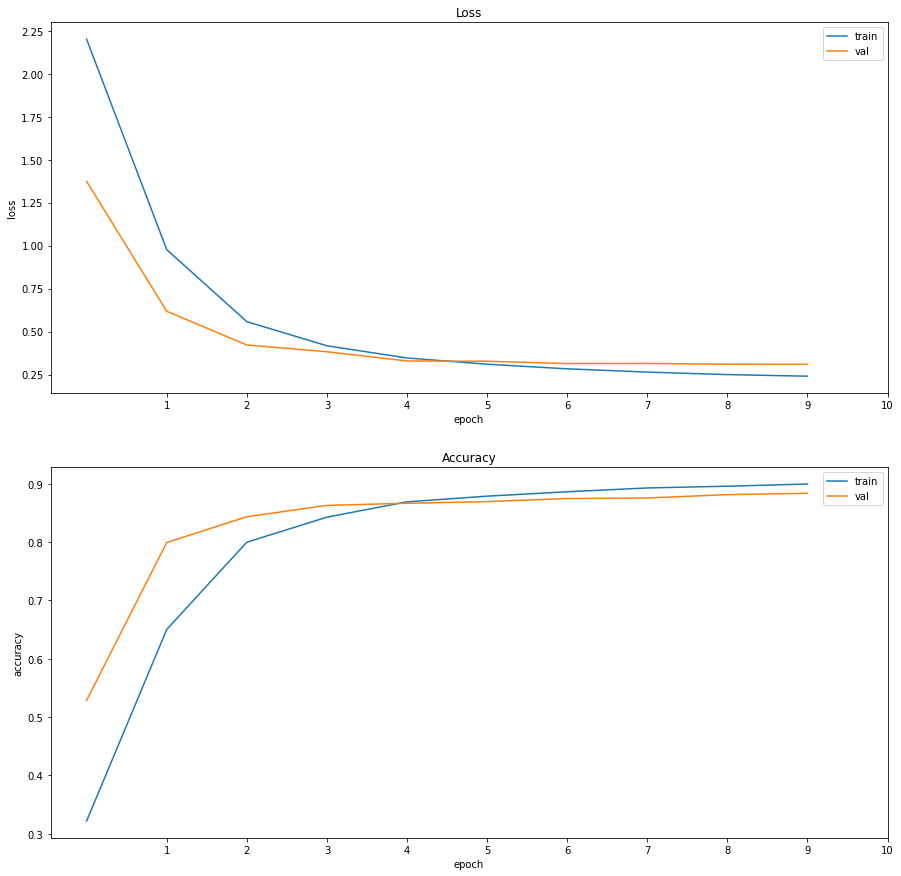

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))

ax1.plot(metrics['train_loss'])
ax1.plot(metrics['val_loss'])
ax1.set_xticks(range(1, params['epochs'] + 1))
ax1.set(xlabel="epoch", ylabel="loss", title="Loss")
ax1.legend(["train", "val"])

ax2.plot(metrics['train_acc'])
ax2.plot(metrics['val_acc'])
ax2.set_xticks(range(1, params['epochs'] + 1))
ax2.set(xlabel="epoch", ylabel="accuracy", title="Accuracy")
ax2.legend(["train", "val"])

plt.show()

### Evaluating on the test data

In [14]:
texts_test = df_test['Text'].tolist()
test_dataloader = prepare_prediction_data(
    texts_test, params['max_len'], params['batch_size'], tokenizer
)
pred_labels_test = model.predict(test_dataloader)
df_test['Emotion_predicted'] = pred_labels_test

/content/prepare_data.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  seqs = torch.tensor(inputs['input_ids'])
/content/prepare_data.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masks = torch.tensor(inputs['attention_mask'])


In [15]:
report = classification_report(df_test['Emotion'].tolist(), df_test['Emotion_predicted'].tolist())
print(report)

              precision    recall  f1-score   support

       anger       0.91      0.86      0.89       299
        fear       0.87      0.87      0.87       265
       happy       0.90      0.90      0.90       701
        love       0.79      0.82      0.80       163
     sadness       0.89      0.94      0.92       626
    surprise       0.88      0.67      0.76        87

    accuracy                           0.89      2141
   macro avg       0.87      0.84      0.86      2141
weighted avg       0.89      0.89      0.89      2141



In [16]:
df_test.head(20)

,Text,Emotion,Emotion_predicted
0,i set off home feeling quite smug,happy,happy
1,i feel reassured that i am dealing with my die...,happy,happy
2,i see this ad i cringe and feel disturbed,sadness,sadness
3,He could see sorrow in the dark eyes which glo...,sadness,sadness
4,i really have much of a clue how my ex actuall...,anger,sadness
5,i think i should ignre this feeling for the sa...,happy,happy
6,i feel so rich when i pass by you i see a penny,happy,happy
7,i feel like a wimpy canoe floating towards a r...,fear,fear
8,i feel honored to be with many wonderful artis...,happy,happy
9,i feel like im being greedy when i say i want ...,anger,anger
